In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
#from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
df=pd.read_csv('preprocessed_datset.csv')  
df.head()

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
0,0,14,29.065927,88.0,174.0,57.5,39.0,95.5,106.5,20.0,1,0
1,0,8,26.989619,78.0,170.0,57.0,36.5,90.0,100.0,20.0,1,0
2,0,16,23.939481,75.0,177.0,59.0,39.0,88.0,104.0,20.0,1,0
3,0,15,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,1,0
4,0,15,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,1,0


In [7]:
X = df.drop('status', axis=1)   # axis=0 for row, axis=1 for column
y = df['status']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)


X_train (4166, 11)
y_train (4166,)
X_test (1042, 11)
y_test (1042,)


In [8]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

In [10]:
X.shape

(5208, 11)

In [11]:
y.shape

(5208,)

In [12]:
np.unique(y)

array([0, 1, 2, 3], dtype=int64)

In [13]:
n_classes = np.unique(y).size

In [14]:
n_classes

4

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [17]:
X_pca

array([[ 1.81593218,  1.81990653, -1.75648721,  1.08767016,  0.31525661,
         1.42859748],
       [-0.70143352, -0.37264012,  1.0469452 , -1.49876726,  0.43826453,
        -0.21999652],
       [ 0.10147435, -0.53513229,  0.19929434, -0.20094493,  0.75968822,
        -0.13382612],
       ...,
       [-0.90694965, -0.36260008,  1.66969338,  1.27264929, -0.41849822,
        -0.26476552],
       [ 0.14522257, -0.47423433,  1.21522311,  1.30557654, -0.9982154 ,
         0.33335656],
       [-1.44455432, -0.54820669,  0.71185735, -0.99971785,  0.7065128 ,
        -0.67453647]])

In [18]:
X_pca.shape

(5208, 6)

In [19]:
round(float(pca.explained_variance_ratio_[0] * 100))

47

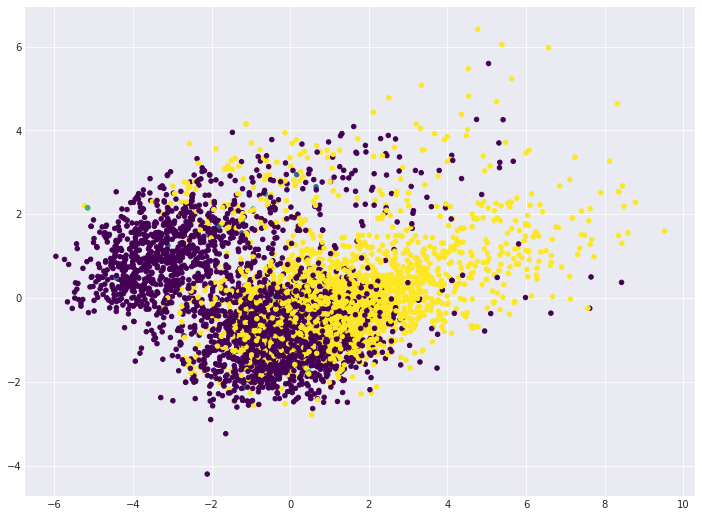

In [20]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');

In [22]:
kmeans = KMeans(n_clusters=n_classes, n_init=100, 
                random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

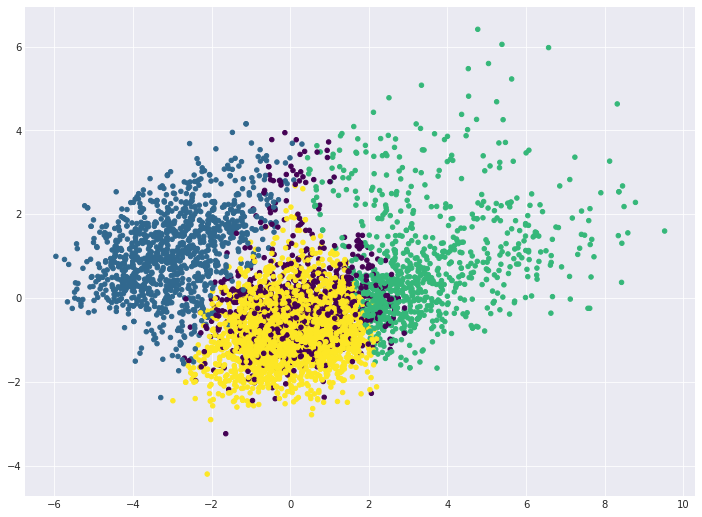

In [23]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  
            cmap='viridis');

In [31]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['Normal', 'Mild',
            'Moderate', 'Severe','all']
tab.columns = ['cluster' + str(i + 1) for i in range(4)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,all
Normal,410,984,146,1344,2884
Mild,2,5,1,9,17
Moderate,4,4,0,5,13
Severe,352,109,757,1076,2294
all,768,1102,904,2434,5208


In [32]:
pd.Series(tab.iloc[:-1,:-1].max(axis=1).values / 
          tab.iloc[:-1,-1].values, index=tab.index[:-1])

Normal      0.466019
Mild        0.529412
Moderate    0.384615
Severe      0.469050
dtype: float64

In [37]:
!pip install tqdm
from tqdm import tqdm_notebook
inertia = []

for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, 
                    random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

D:\DOWNLOADS\Anconda\envs\majorproject\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/4 [00:00<?, ?it/s]

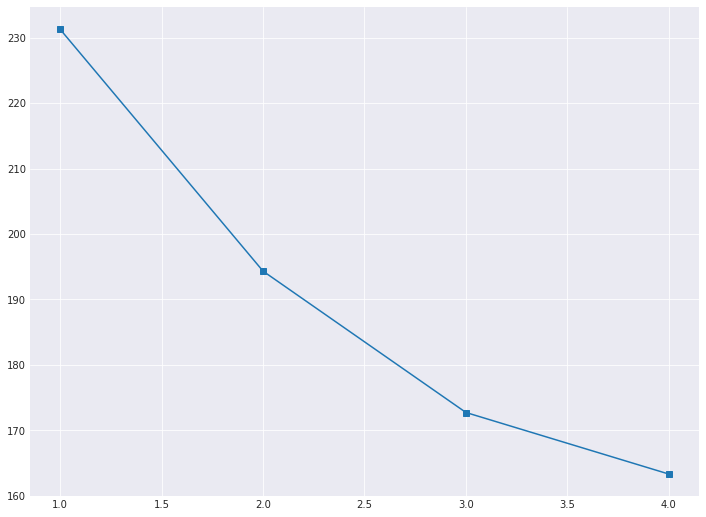

In [39]:
plt.plot(range(1, 5), inertia, marker='s');

In [44]:
d = {}
for k in range(1, 4):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

In [45]:
d

{1: -0.5437483835703175, 2: 0.5845317043486197, 3: 0.43548403048088474}

In [46]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

In [47]:
print('KMeans: ARI =', metrics.adjusted_rand_score(y, cluster_labels))
print('Agglomerative CLustering: ARI =', 
      metrics.adjusted_rand_score(y, ag.labels_))

KMeans: ARI = 0.08112161585654745
Agglomerative CLustering: ARI = 0.09173423854797427
